In [1]:
import sys
sys.path.append('../')
from src import mlp_quantile
from src import metrics as _metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import seaborn as sns

sns.set(rc={'figure.figsize':(20,8)})
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
pd.set_option('display.max_rows', 120)

* https://towardsdatascience.com/quantile-regression-from-linear-models-to-trees-to-deep-learning-af3738b527c3
* https://towardsdatascience.com/lightgbm-for-quantile-regression-4288d0bb23fd
* https://towardsdatascience.com/deep-quantile-regression-in-tensorflow-1dbc792fe597
* https://github.com/sachinruk/KerasQuantileModel/blob/master/Keras%20Quantile%20Model.ipynb

## Reading / Displaying the Data 

In [2]:
df_dataset_v2 = pd.read_csv('../data/forecast_dataset_exp11.csv')

In [3]:
df_dataset_v2.describe()

,month,Y,hc_cluster_1,hc_cluster_2,hc_cluster_3,hc_cluster_4,hc_cluster_5,hc_cluster_6,hc_cluster_7,hc_cluster_8,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,...,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,6.341538,116.636923,0.836154,0.013077,0.018462,0.016154,0.018462,0.018462,0.006154,0.064615,...,0.010769,0.005385,0.008462,0.064615,0.018462,0.018462,0.006154,0.008462,0.010000,0.013077
std,3.596290,241.937405,0.370278,0.113648,0.134665,0.126116,0.134665,0.134665,0.078235,0.245941,...,0.103254,0.073210,0.091632,0.245941,0.134665,0.134665,0.078235,0.091632,0.099537,0.113648
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,41.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,98.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,12.000000,2063.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
df_dataset_v2.head()

,code,year_month,month,Y,hc_cluster_1,hc_cluster_2,hc_cluster_3,hc_cluster_4,hc_cluster_5,hc_cluster_6,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
0,0671c2b9132a3f5215a4212ce0691694,2016-11,11,664,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0671c2b9132a3f5215a4212ce0691694,2016-12,12,225,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0671c2b9132a3f5215a4212ce0691694,2017-01,1,211,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0671c2b9132a3f5215a4212ce0691694,2017-02,2,634,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0671c2b9132a3f5215a4212ce0691694,2017-03,3,1343,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_cols = [c for c in df_dataset_v2.columns if c not in ['year_month', 'Y'] and 'hc_cluster' not in c]

In [6]:
df_dataset_v2['code'] = df_dataset_v2['code'].astype('category').cat.codes

In [7]:
X_cols

['code',
 'month',
 'kmeans_cluster_0',
 'kmeans_cluster_1',
 'kmeans_cluster_2',
 'kmeans_cluster_3',
 'kmeans_cluster_4',
 'kmeans_cluster_5',
 'kmeans_cluster_6',
 'kmeans_cluster_7',
 'kmeans_cluster_8',
 'cat_code_0',
 'cat_code_1',
 'cat_code_2',
 'cat_code_3',
 'cat_code_4',
 'cat_code_5',
 'cat_code_6',
 'cat_code_7',
 'cat_code_8',
 'cat_code_9',
 'cat_code_10']

In [8]:
df_dataset_v2[X_cols].head()

,code,month,kmeans_cluster_0,kmeans_cluster_1,kmeans_cluster_2,kmeans_cluster_3,kmeans_cluster_4,kmeans_cluster_5,kmeans_cluster_6,kmeans_cluster_7,...,cat_code_1,cat_code_2,cat_code_3,cat_code_4,cat_code_5,cat_code_6,cat_code_7,cat_code_8,cat_code_9,cat_code_10
0,0,11,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,12,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Splitting the Sets
* We will use the temporal series cross validation
* 3 months minimum intervals
* 3 training, 6 validation, 3 test
* 4 training, 5 validation, 3 test
* 5 training, 4 validation, 3 test
* 6 training, 3 validation, 3 test

In [9]:
df_train_val_test = pd.read_csv('../data/train_val_test.csv')

In [10]:
df_train_val_test

,set,train,val,reserved
0,0,"['2016-06', '2016-07', '2016-08']","['2016-09', '2016-10', '2016-11', '2016-12', '...",False
1,1,"['2016-06', '2016-07', '2016-08', '2016-09']","['2016-10', '2016-11', '2016-12', '2017-01', '...",False
2,2,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2016-11', '2016-12', '2017-01', '2017-02']",False
3,3,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2016-12', '2017-01', '2017-02']",False
4,4,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2017-01', '2017-02']",False
5,5,"['2016-06', '2016-07', '2016-08', '2016-09', '...",['2017-02'],False
6,6,"['2016-06', '2016-07', '2016-08', '2016-09', '...","['2017-03', '2017-04', '2017-05']",True


## Regressors Init

In [11]:
regressors = {}
RANDOM_STATE = 42
q =0.5

In [12]:
import lightgbm as lgb
gbm = lgb.LGBMRegressor(random_state=RANDOM_STATE)
regressors['gbm'] = gbm

In [13]:
import lightgbm as lgb
gbm_q = lgb.LGBMRegressor(alpha=q, objective = 'quantile',
    metric = 'quantile',random_state=RANDOM_STATE)
regressors['gbm_q'] = gbm_q

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
gb_q = GradientBoostingRegressor(loss='quantile', alpha=q)
regressors['gb_q'] = gb_q

In [15]:

mlp_q = mlp_quantile.QuantileModel(input_dims=len(X_cols), q=q)
regressors['mlp_q'] = mlp_q

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Train Eval



In [17]:
def parse_str_list(str_list):
    result = str_list.replace("'","").replace('[','').replace(']','').replace(' ', '').split(',')
    return result

In [18]:
sets = list(df_train_val_test[~df_train_val_test.reserved].set.values)
sets

[0, 1, 2, 3, 4, 5]

In [19]:
results = []
for r_name, r in regressors.items():
    for s in sets:
        df_set = df_train_val_test[~df_train_val_test.reserved & (df_train_val_test.set == s)]

        x_scaler = MinMaxScaler()
        
        train_years = parse_str_list(df_set.train.values[0])
        val_years = parse_str_list(df_set.val.values[0])
        print(f'Training {r_name} on set {s}')
        

        df_train = df_dataset_v2[df_dataset_v2.year_month.isin(train_years)]
        df_val = df_dataset_v2[df_dataset_v2.year_month.isin(val_years)]
    
        y_train = df_train['Y'].values    
        y_val = df_val['Y'].values
        
        if 'mlp' in r_name:
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train, 
                       X_val = x_scaler.transform(df_val[X_cols]), y_val = y_val)
        else: 
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train)
        
        print(f'Validating {r_name}  on set {s}')
        
        y_pred_val = r_inst.predict(x_scaler.transform(df_val[X_cols]))
        
        y_pred_val = y_pred_val
        m = _metrics.applyRegressionMetrics(y=y_val, y_pred=y_pred_val)
        m['reg_inst'] = r_inst
        m['r_name'] = r_name
        m['set'] = s
        results.append(m)

    print()
df_results = pd.DataFrame(results)    

Training gbm on set 0
Validating gbm  on set 0
Training gbm on set 1
Validating gbm  on set 1
Training gbm on set 2
Validating gbm  on set 2
Training gbm on set 3
Validating gbm  on set 3
Training gbm on set 4
Validating gbm  on set 4
Training gbm on set 5
Validating gbm  on set 5

Training gbm_q on set 0
Validating gbm_q  on set 0
Training gbm_q on set 1
Validating gbm_q  on set 1
Training gbm_q on set 2
Validating gbm_q  on set 2
Training gbm_q on set 3
Validating gbm_q  on set 3
Training gbm_q on set 4
Validating gbm_q  on set 4
Training gbm_q on set 5
Validating gbm_q  on set 5

Training gb_q on set 0
Validating gb_q  on set 0
Training gb_q on set 1
Validating gb_q  on set 1
Training gb_q on set 2
Validating gb_q  on set 2
Training gb_q on set 3
Validating gb_q  on set 3
Training gb_q on set 4
Validating gb_q  on set 4
Training gb_q on set 5
Validating gb_q  on set 5

Training mlp_q on set 0
Validating mlp_q  on set 0
Training mlp_q on set 1
Validating mlp_q  on set 1
Training mlp_

In [20]:
metric_list = []

In [21]:
df_results.groupby('r_name').agg({'RMSE':[pd.Series.mean, pd.Series.std],
                                  'MDAPE':[pd.Series.mean, pd.Series.std],'MAPE':[pd.Series.mean, pd.Series.std],
                                  'MSE':[pd.Series.mean, pd.Series.std],
                                  'MAE':[pd.Series.mean, pd.Series.std],'R2':[pd.Series.mean, pd.Series.std],})

RMSE                MDAPE                MAPE            \
              mean        std      mean       std      mean       std   
r_name                                                                  
gb_q    199.498823  25.896408  0.620488  0.033019  2.846529  1.040011   
gbm     157.916317  26.877699  0.819981  0.105161  5.148311  1.392523   
gbm_q   213.738329  28.479749  0.704246  0.023028  2.401626  0.732290   
mlp_q   237.099924  25.066156  0.812347  0.083397  4.384538  0.988158   

                 MSE                       MAE                   R2            
                mean           std        mean        std      mean       std  
r_name                                                                         
gb_q    40358.633473   9536.519989   81.750823  12.101587  0.260885  0.101741  
gbm     25539.571995   8035.784919   89.545630  12.854005  0.538140  0.089490  
gbm_q   46359.986767  11115.429591   90.569631  13.137287  0.155051  0.084910  
mlp_q   56739.967432  11264.792389  100.432629  16.026254 -0.043890  0.063110

Training gbm on set 6
Validating gbm on set 6 and 2017-03
932 125
RMSE : 152.1191
MAPE': 2.8938
MDAPE': 0.7273
MSE: 23140.2080
MAE: 71.8880
R2: 0.5883


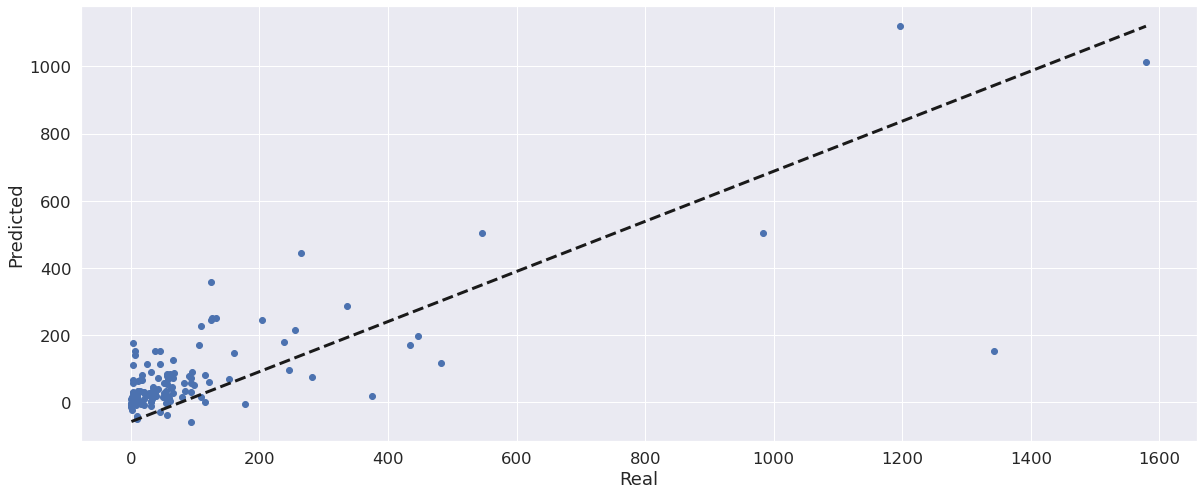

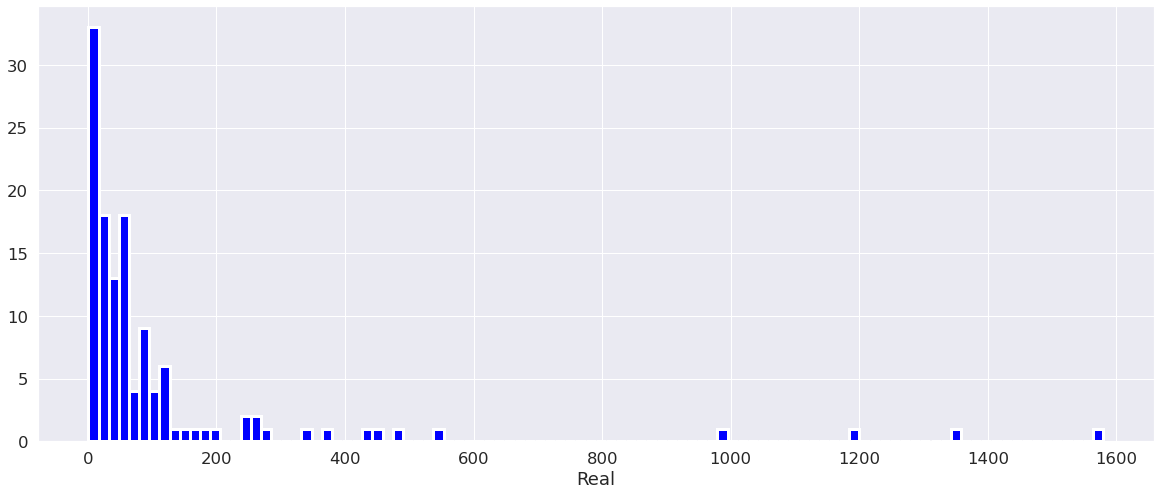

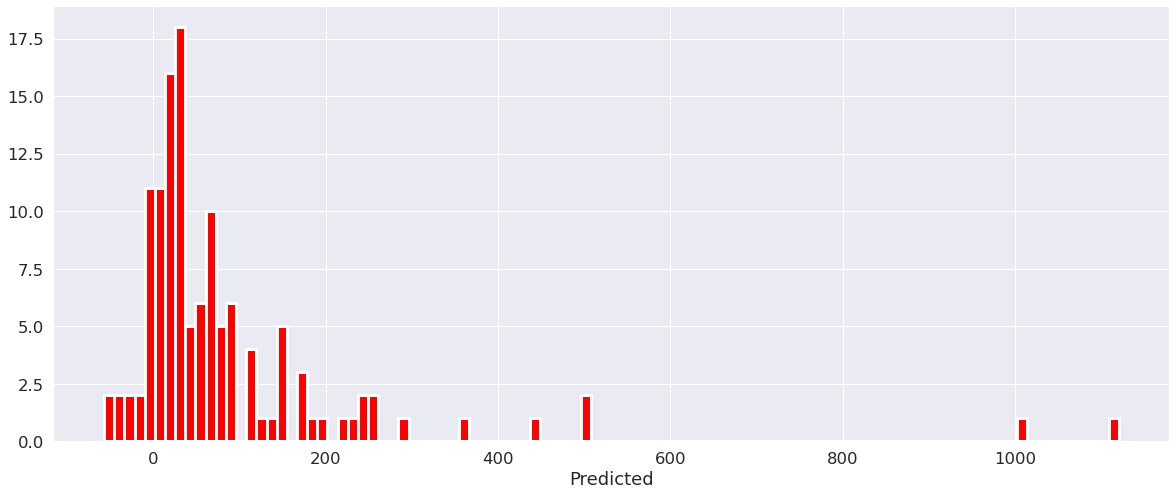


Validating gbm on set 6 and 2017-04
932 122
RMSE : 137.3650
MAPE': 2.8735
MDAPE': 0.6248
MSE: 18869.1475
MAE: 66.9672
R2: 0.6142


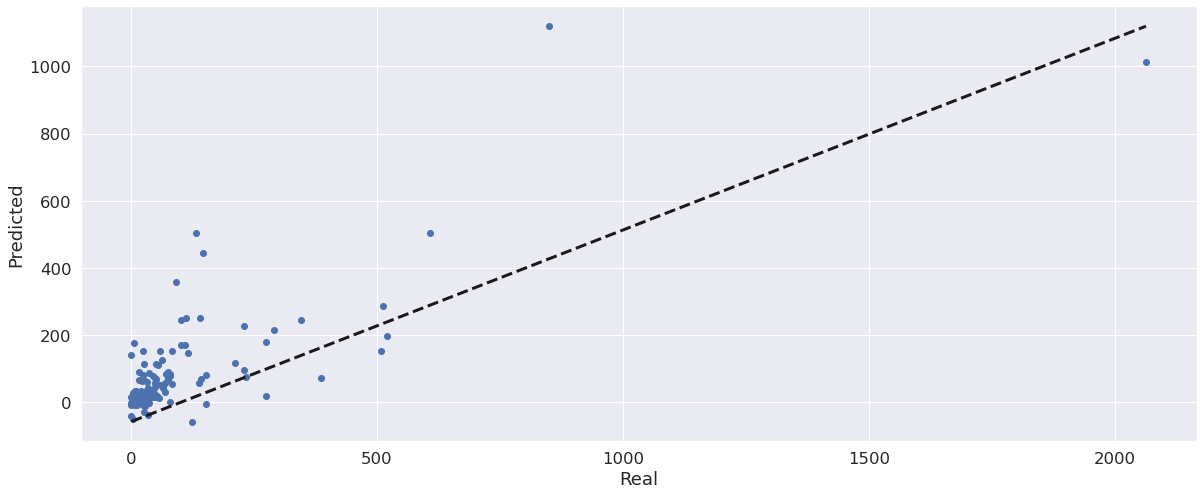

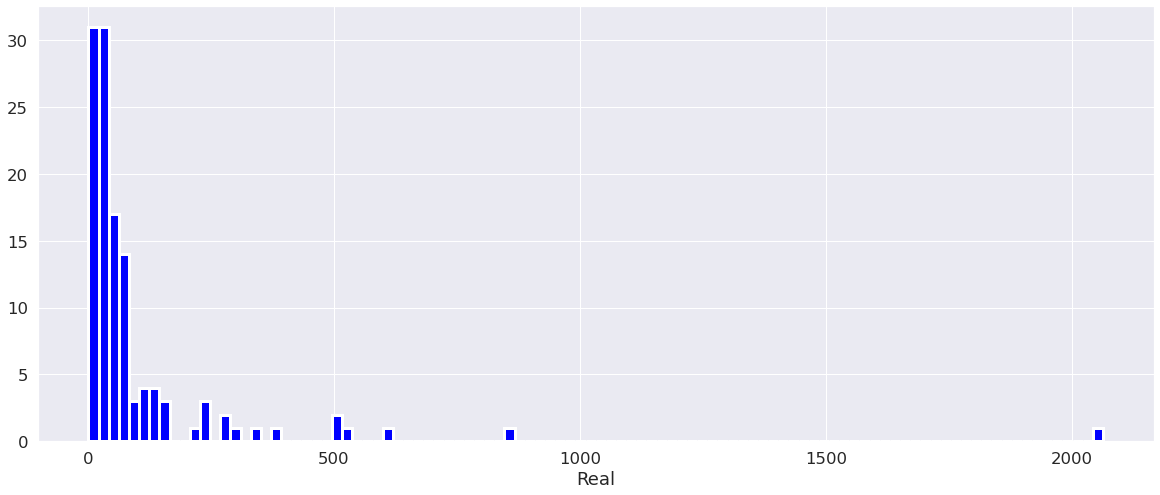

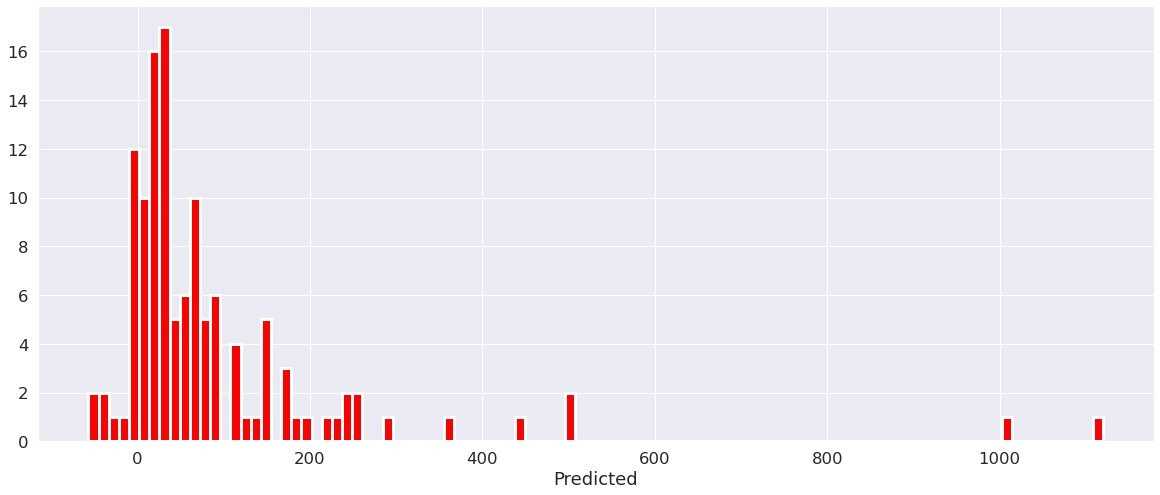


Validating gbm on set 6 and 2017-05
932 121
RMSE : 197.1363
MAPE': 9.8993
MDAPE': 0.6636
MSE: 38862.7190
MAE: 96.8017
R2: 0.4787


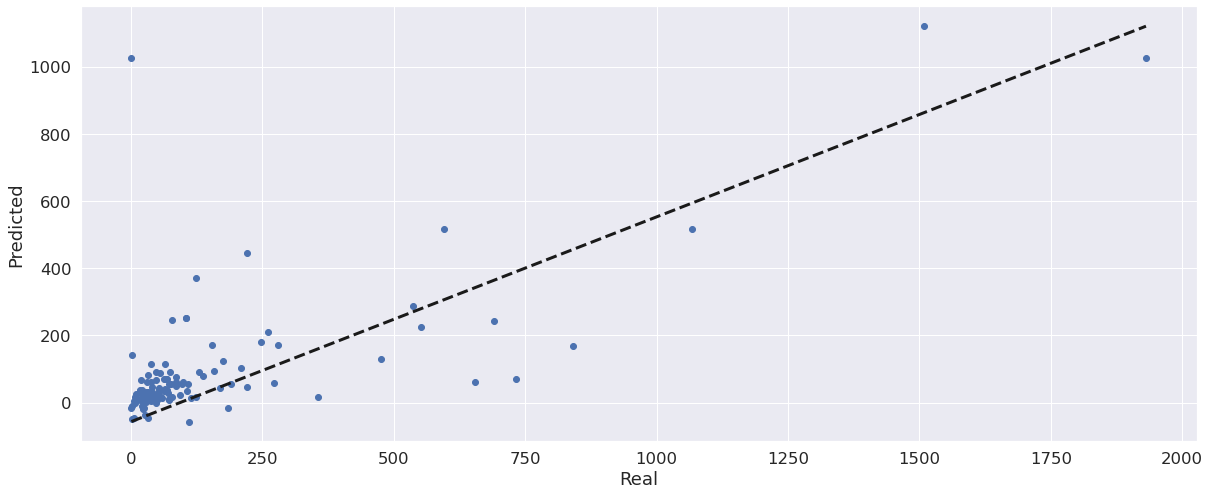

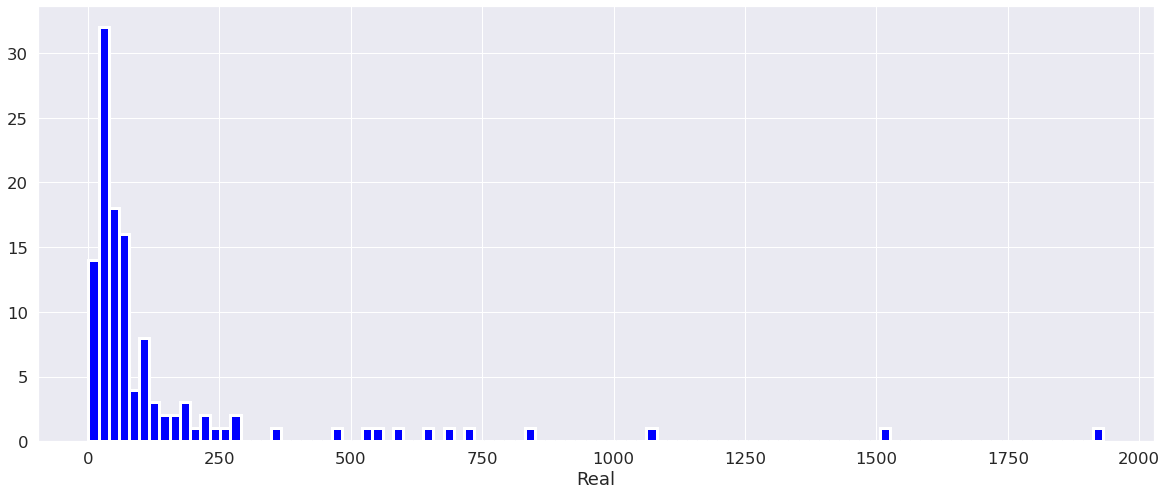

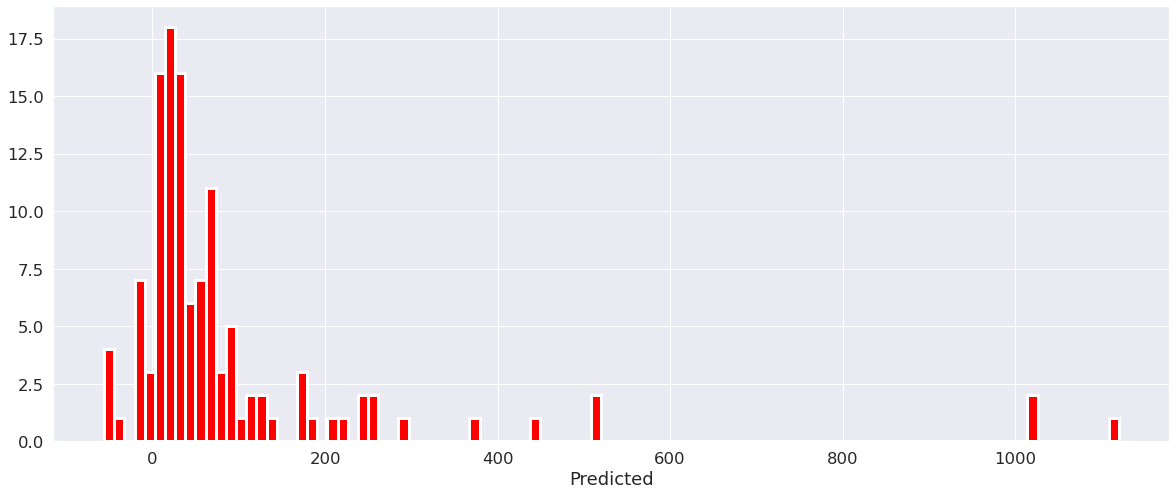


Training gbm_q on set 6
Validating gbm_q on set 6 and 2017-03
932 125
RMSE : 200.0441
MAPE': 1.4769
MDAPE': 0.5385
MSE: 40017.6480
MAE: 75.7920
R2: 0.2881


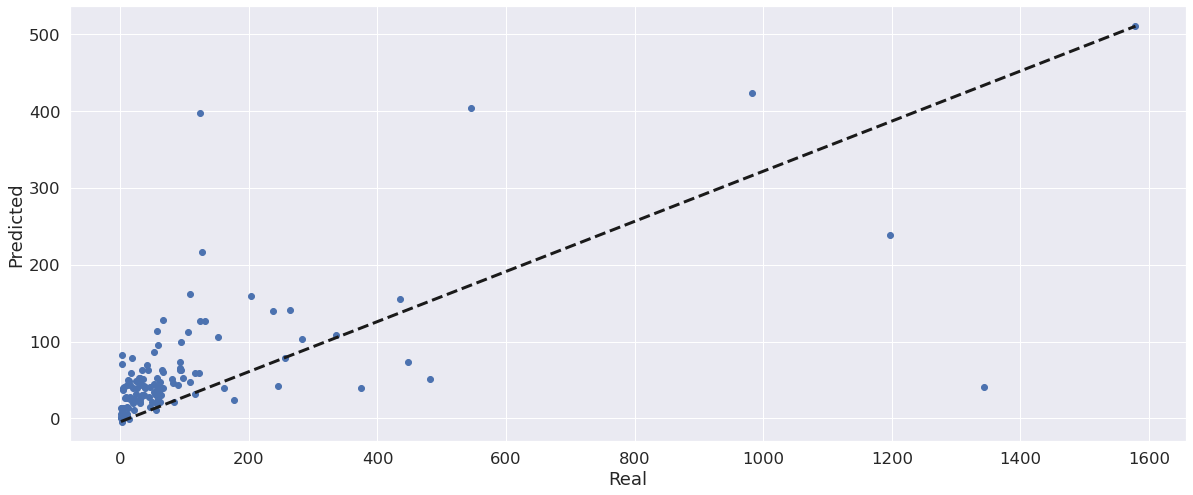

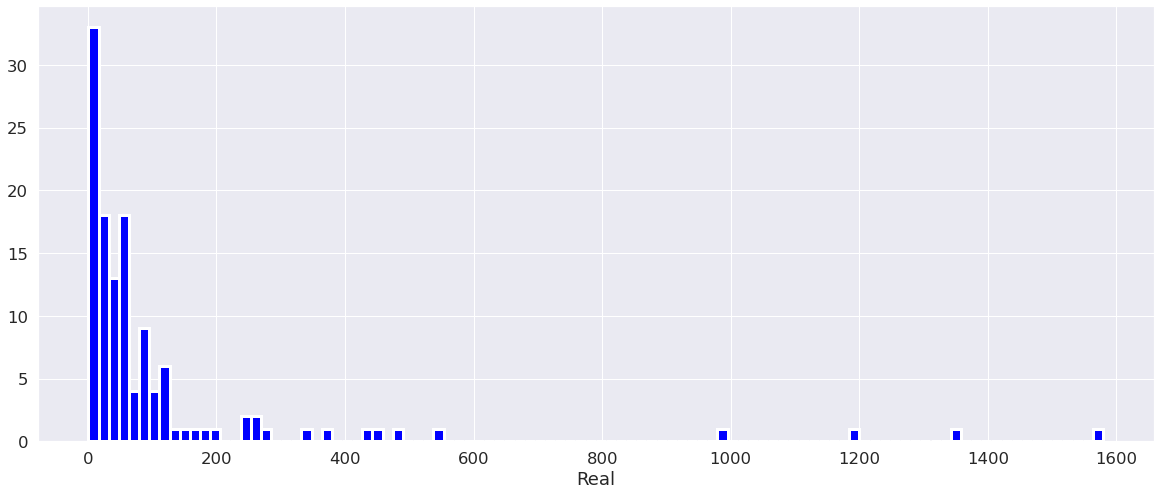

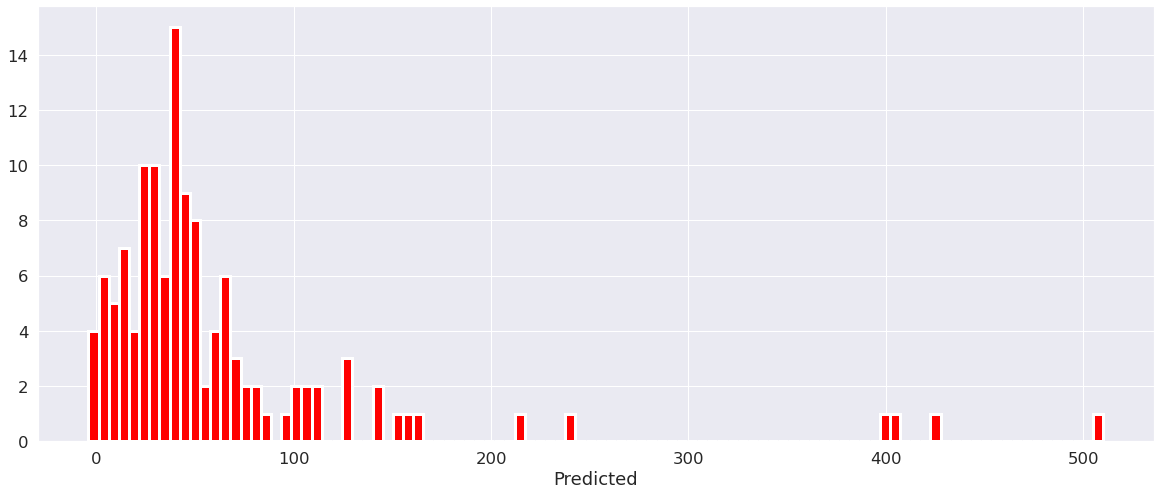


Validating gbm_q on set 6 and 2017-04
932 122
RMSE : 181.9414
MAPE': 0.9811
MDAPE': 0.5205
MSE: 33102.6803
MAE: 67.6148
R2: 0.3232


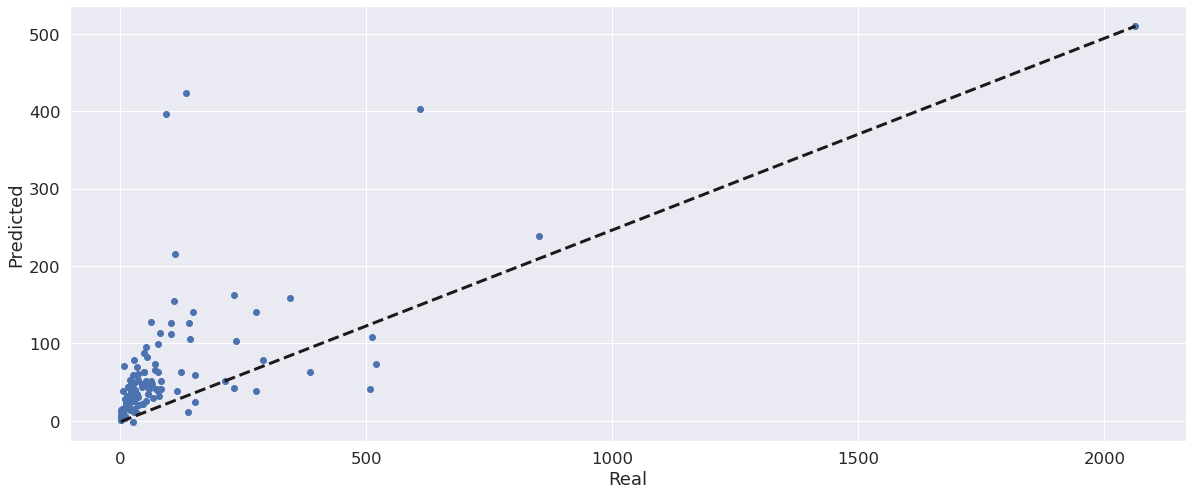

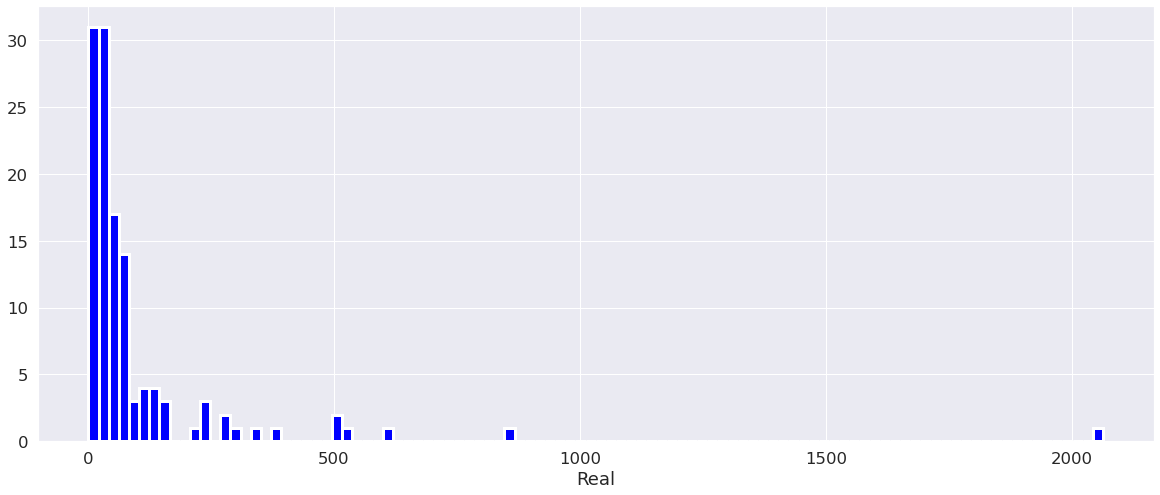

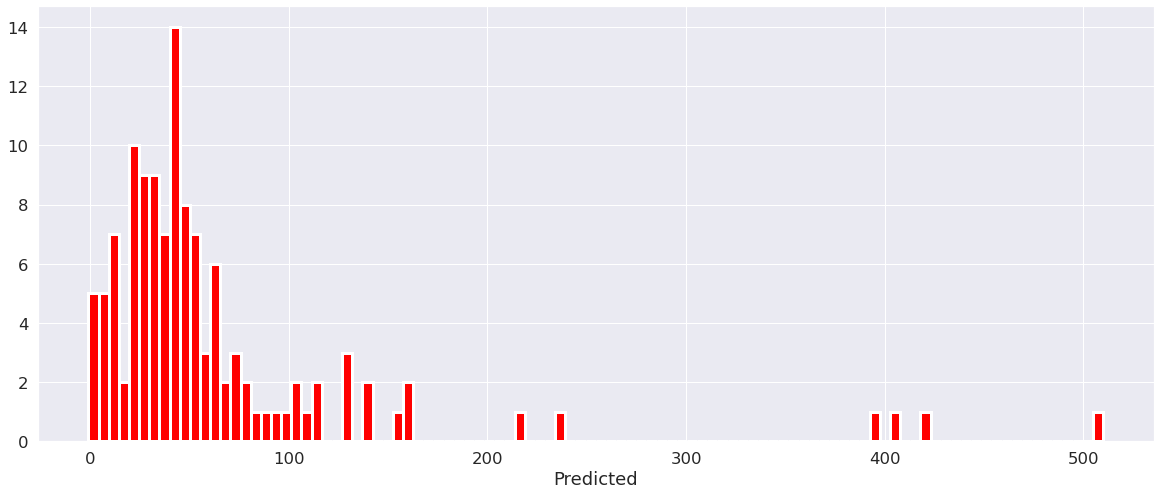


Validating gbm_q on set 6 and 2017-05
932 121
RMSE : 235.9158
MAPE': 1.3425
MDAPE': 0.5000
MSE: 55656.2810
MAE: 99.1405
R2: 0.2535


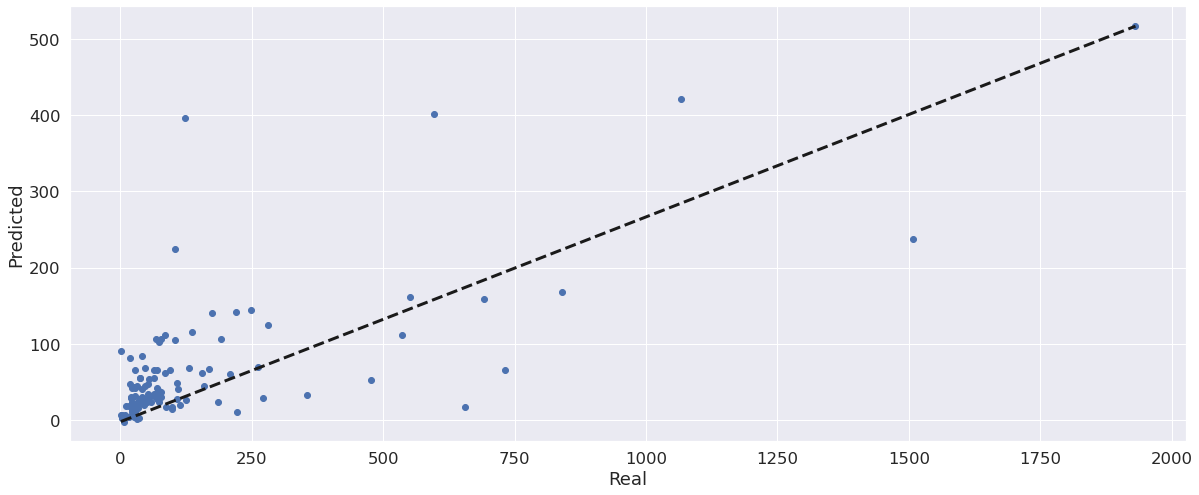

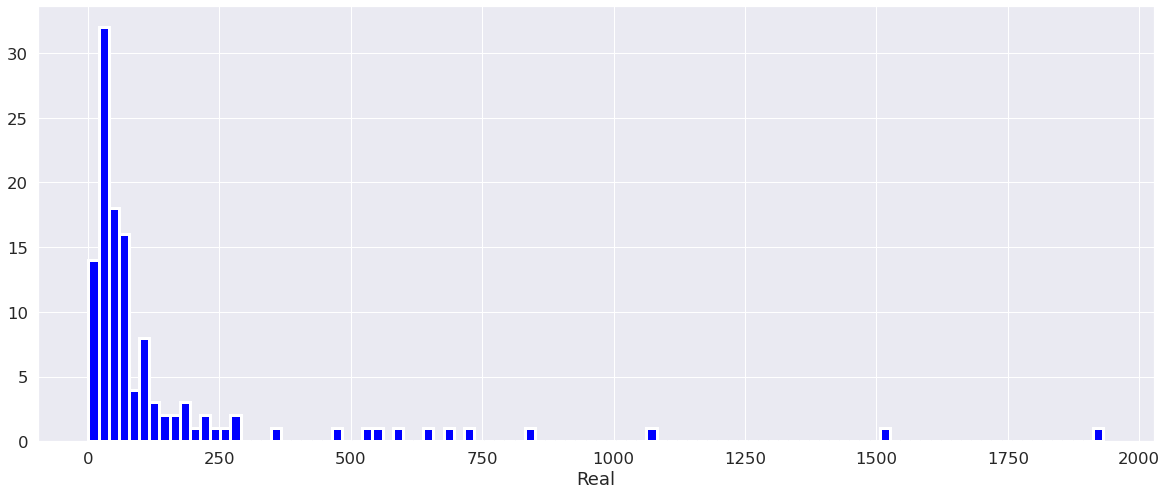

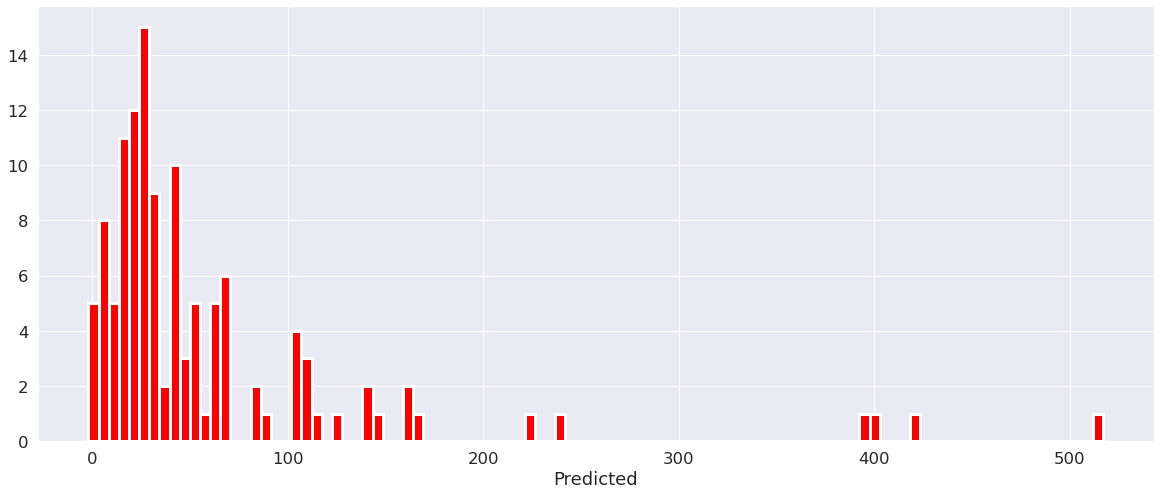


Training gb_q on set 6
Validating gb_q on set 6 and 2017-03
932 125
RMSE : 200.3096
MAPE': 1.7618
MDAPE': 0.5806
MSE: 40123.9200
MAE: 75.5840
R2: 0.2862


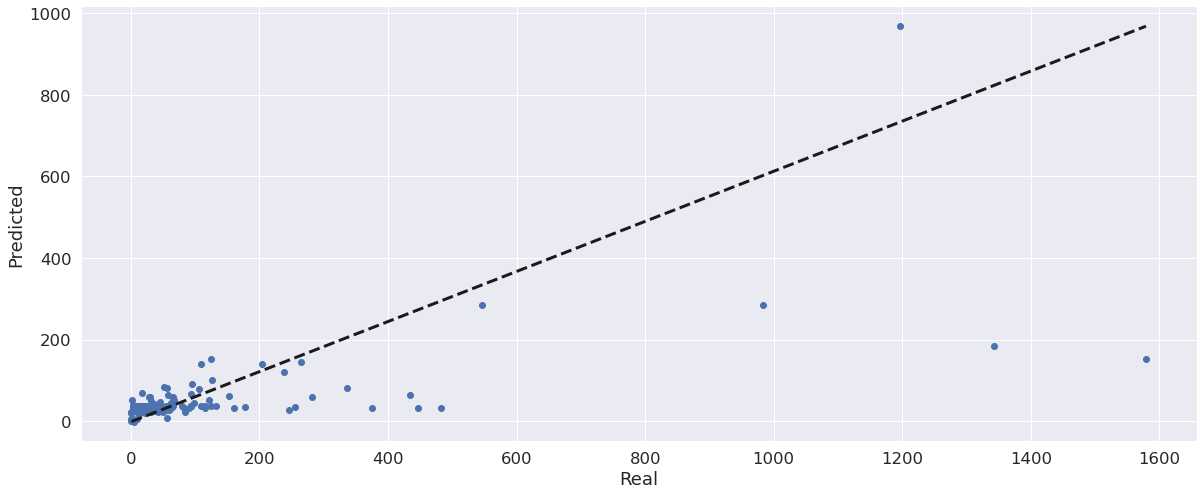

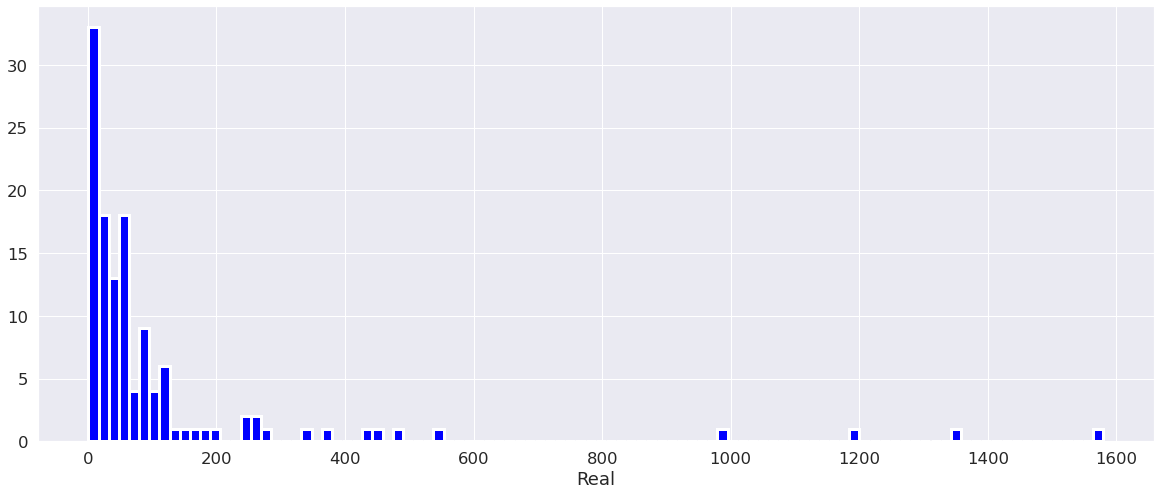

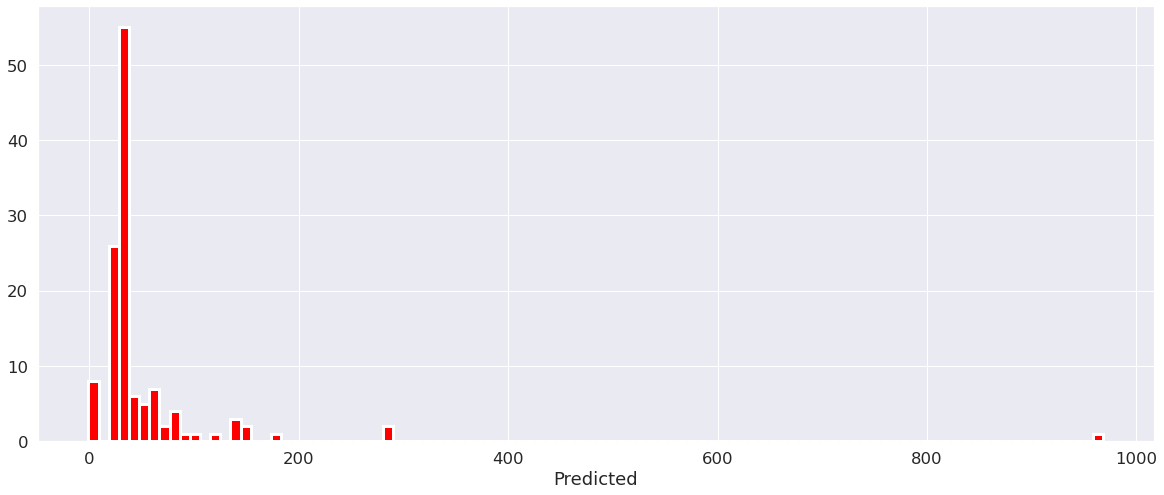


Validating gb_q on set 6 and 2017-04
932 122
RMSE : 199.3333
MAPE': 0.9982
MDAPE': 0.5486
MSE: 39733.7459
MAE: 65.6803
R2: 0.1876


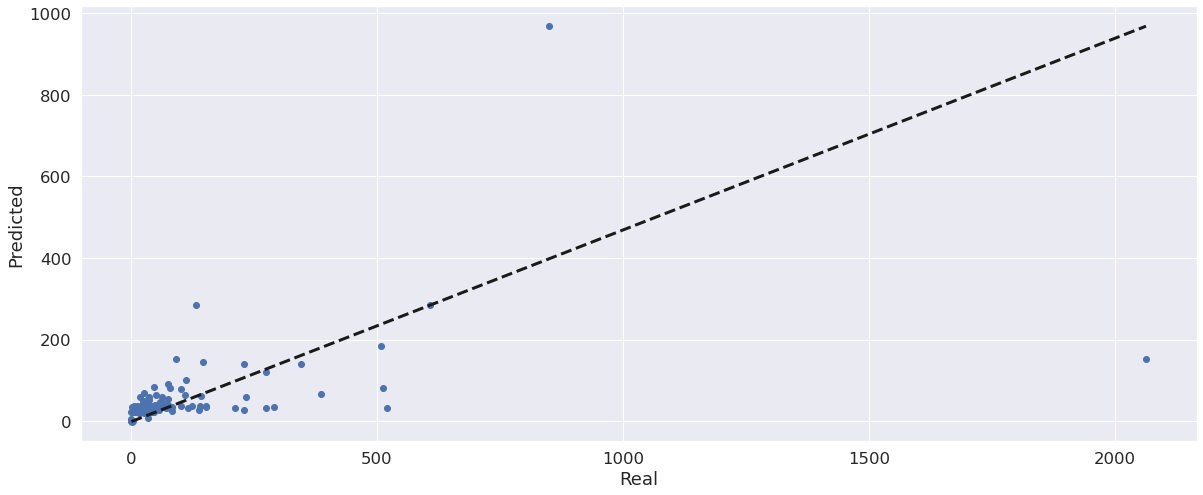

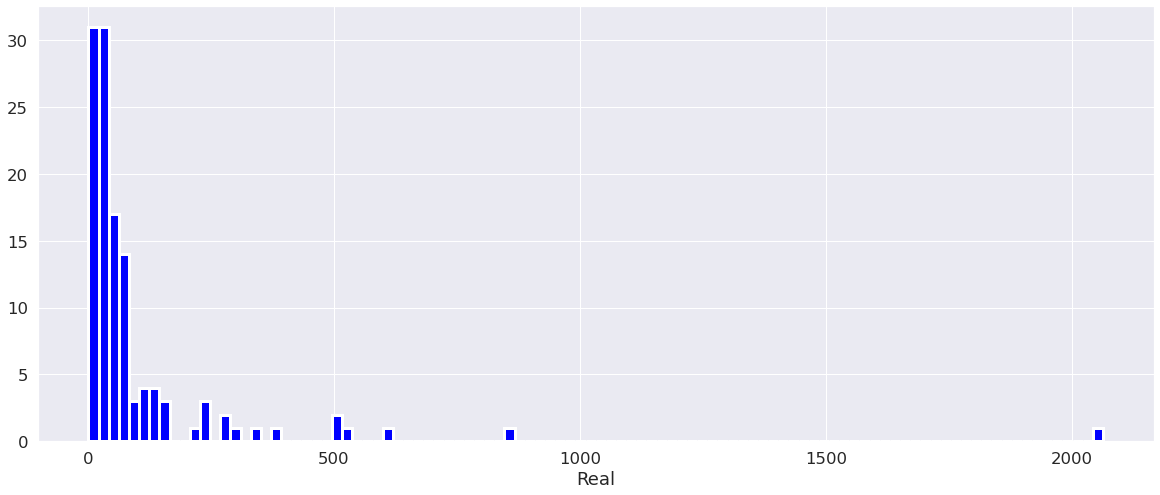

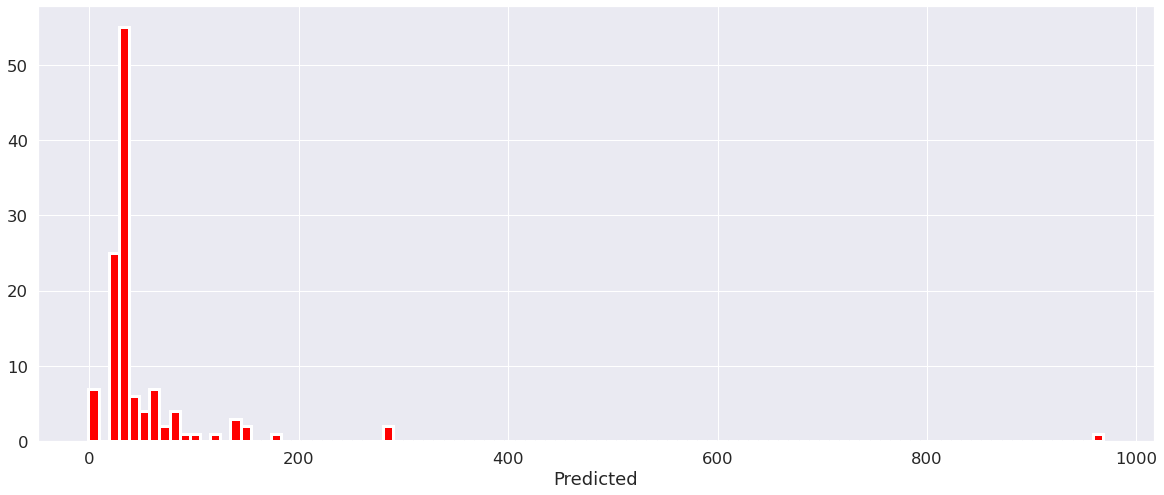


Validating gb_q on set 6 and 2017-05
932 121
RMSE : 236.8514
MAPE': 0.7276
MDAPE': 0.4762
MSE: 56098.6033
MAE: 96.4380
R2: 0.2476


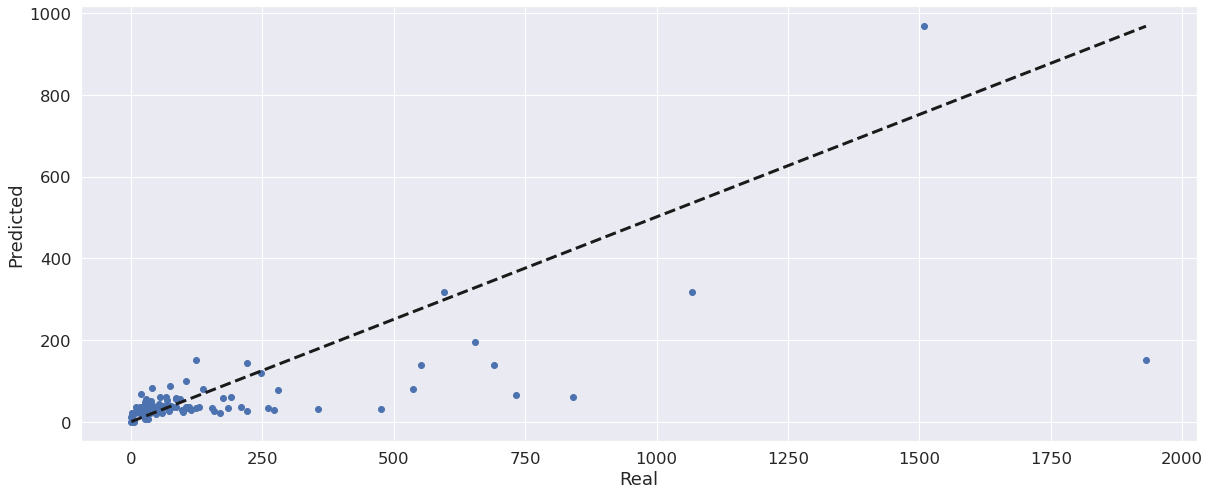

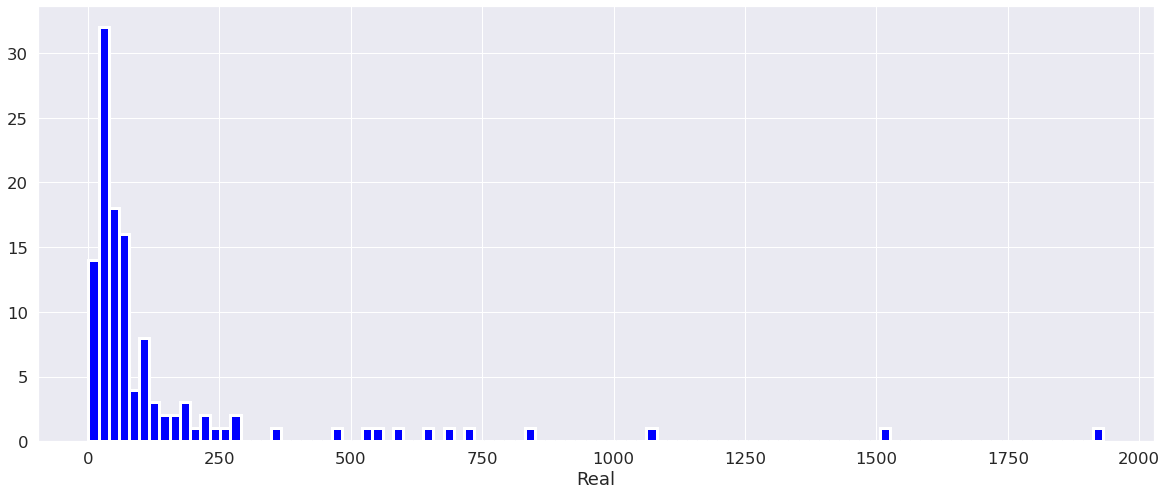

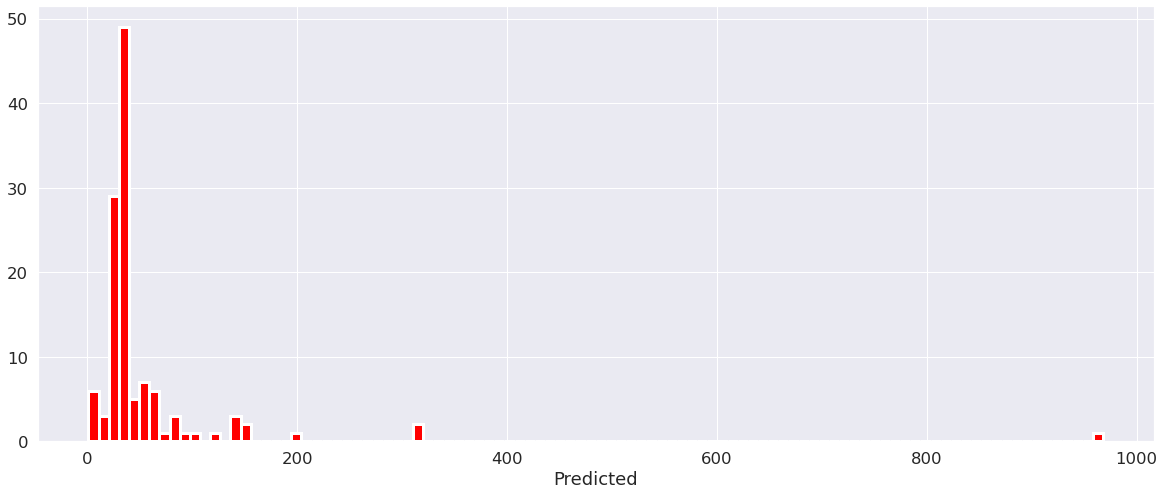


Training mlp_q on set 6
Validating mlp_q on set 6 and 2017-03
932 125
RMSE : 246.4460
MAPE': 3.8415
MDAPE': 0.7803
MSE: 60735.6160
MAE: 97.3120
R2: -0.0805


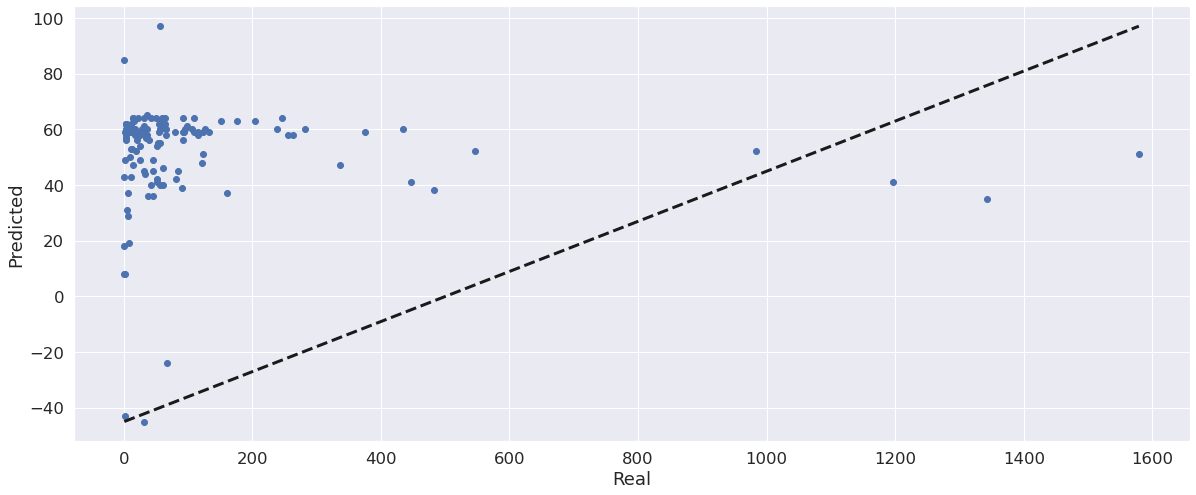

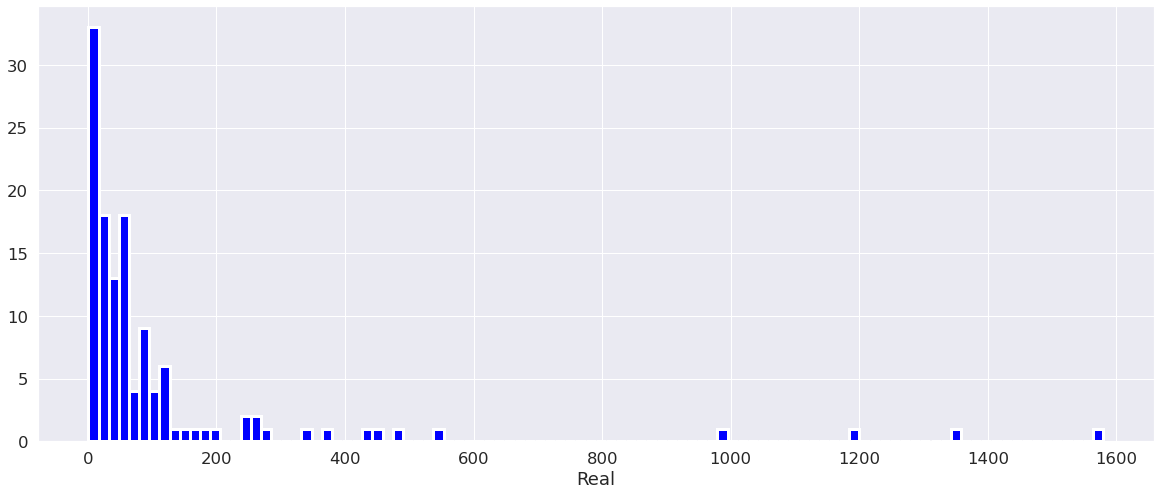

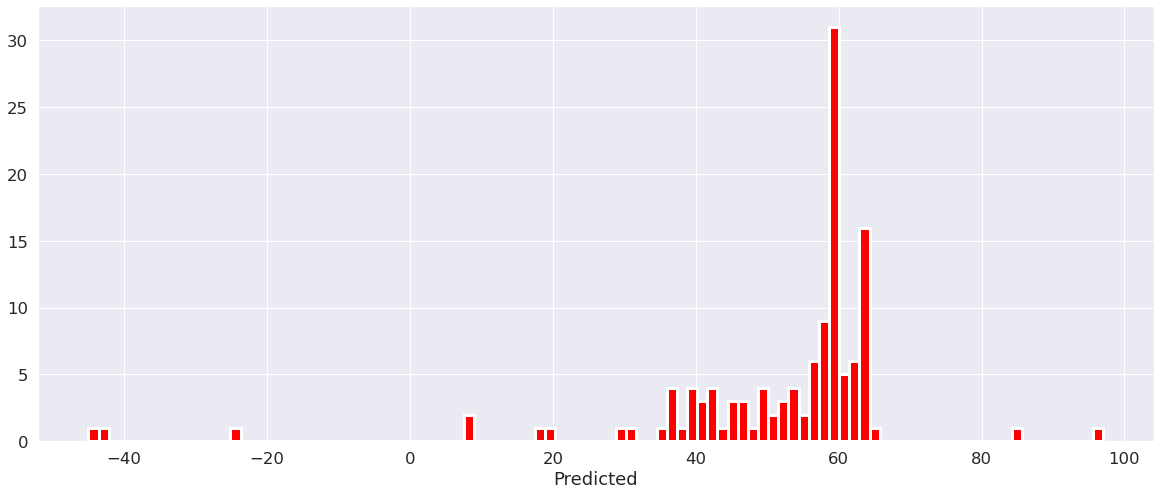


Validating mlp_q on set 6 and 2017-04
932 122
RMSE : 229.1524
MAPE': 2.2156
MDAPE': 0.7651
MSE: 52510.8033
MAE: 83.8033
R2: -0.0736


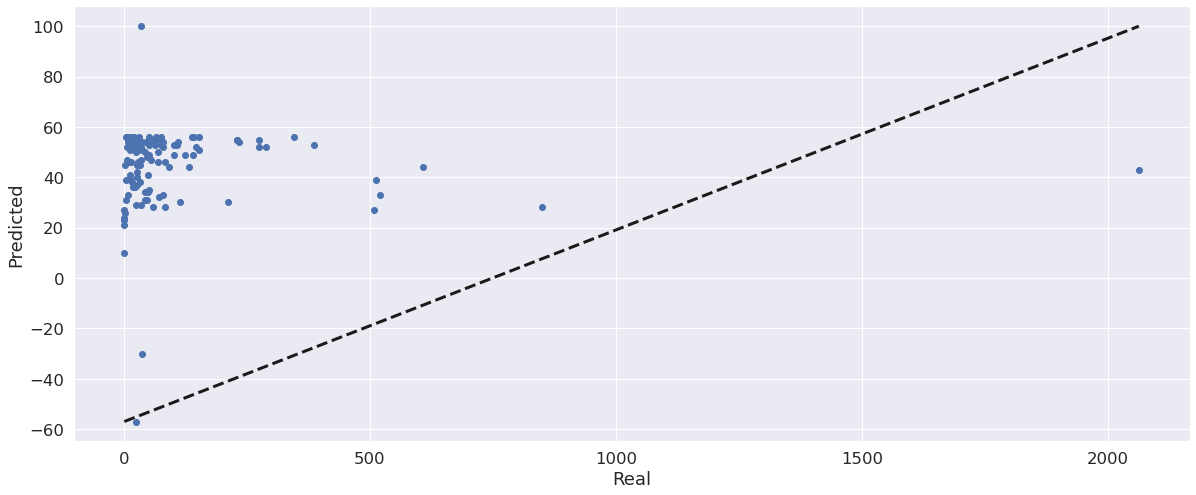

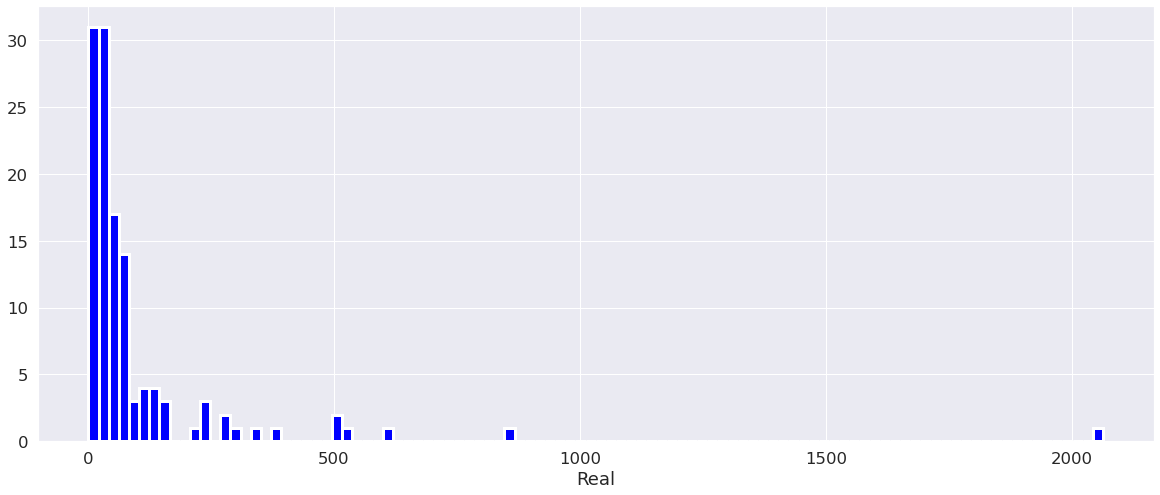

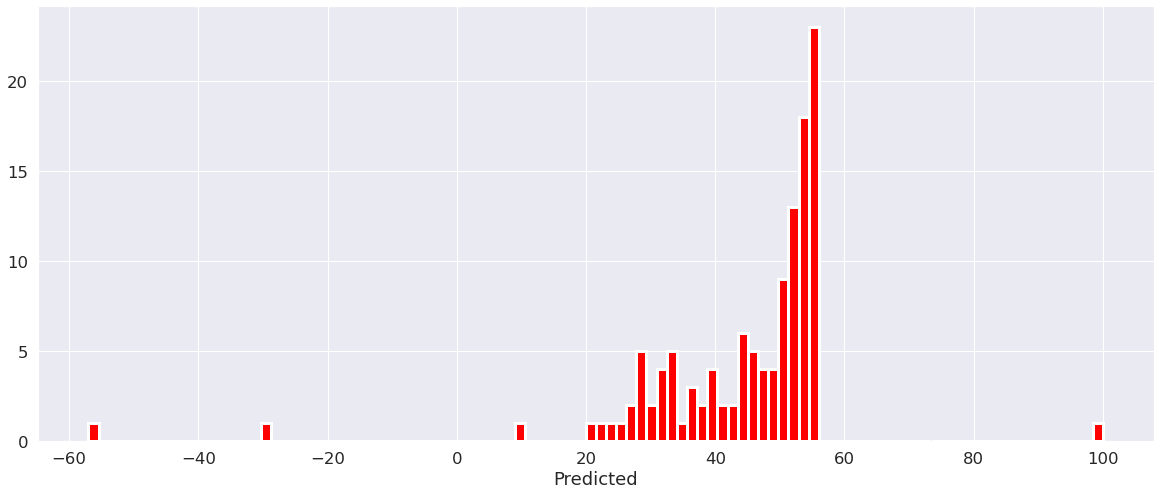


Validating mlp_q on set 6 and 2017-05
932 121
RMSE : 294.0343
MAPE': 1.1087
MDAPE': 0.6423
MSE: 86456.1653
MAE: 118.8595
R2: -0.1596


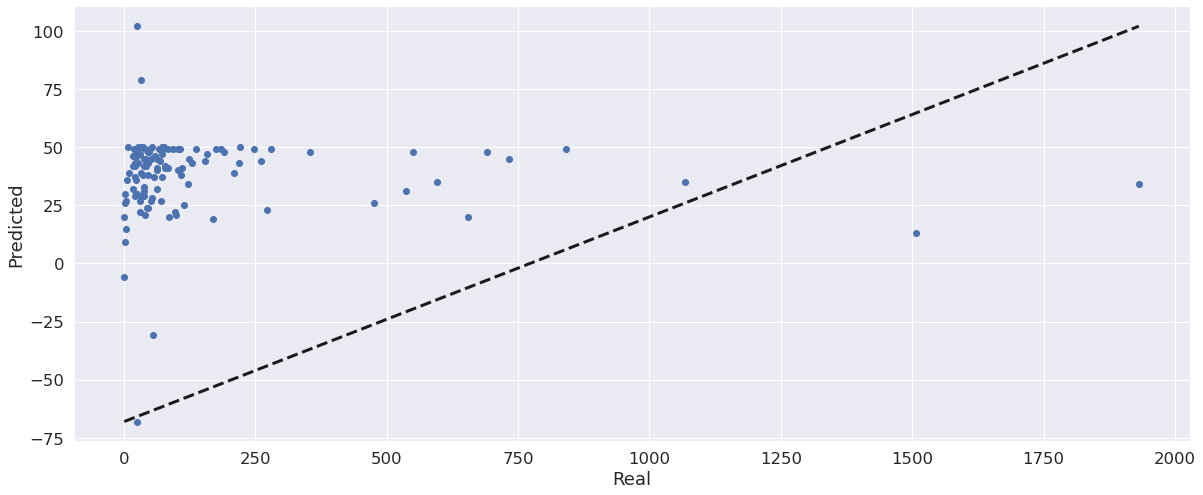

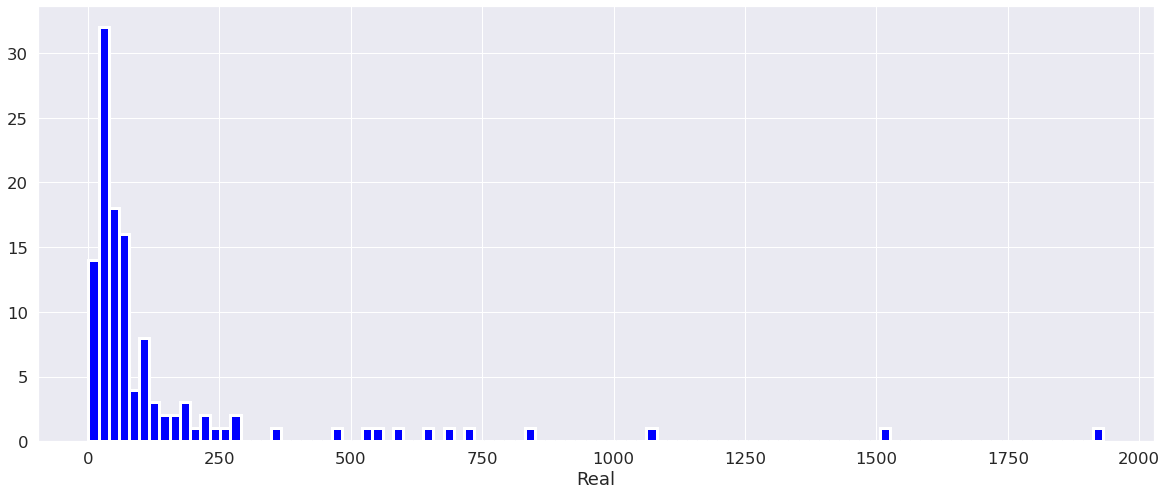

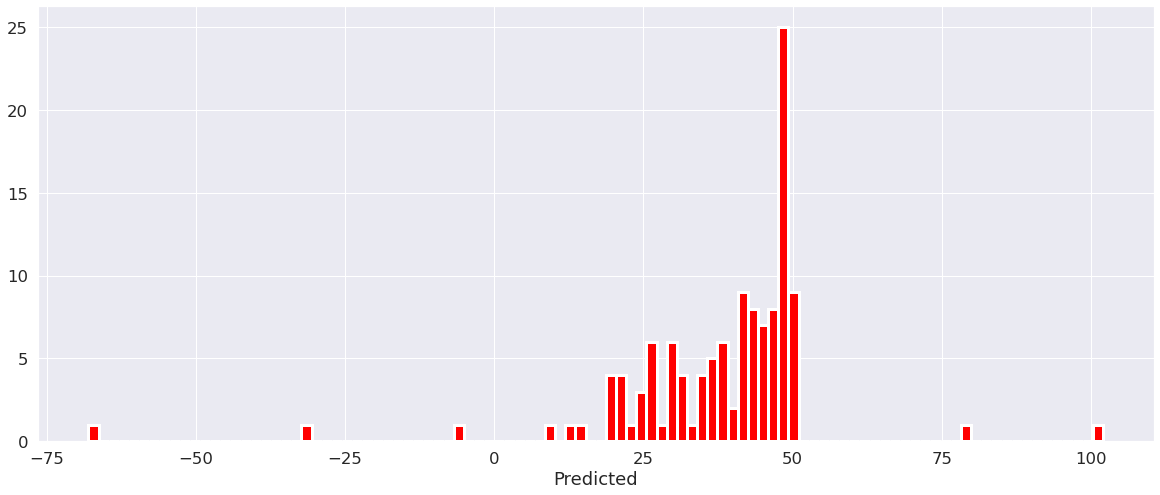

In [22]:
results = []
for r_name, r in regressors.items():
    s=6
    x_scaler = StandardScaler()

    df_set = df_train_val_test[(df_train_val_test.set == s)]

    x_scaler = MinMaxScaler()

    train_years = parse_str_list(df_set.train.values[0])
    val_years = parse_str_list(df_set.val.values[0])
    print(f'Training {r_name} on set {s}')

    df_train = df_dataset_v2[df_dataset_v2.year_month.isin(train_years)]    

    y_train = df_train['Y'].values    
    df_val = df_dataset_v2[df_dataset_v2.year_month.isin(val_years)]
    y_val = df_val['Y'].values
        
    if 'mlp' in r_name:
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train, 
                       X_val = x_scaler.transform(df_val[X_cols]), y_val = y_val)
    else: 
            r_inst = r.fit(X=x_scaler.fit_transform(df_train[X_cols]), y=y_train)
        
    for val_year in val_years:
        df_val = df_dataset_v2[df_dataset_v2.year_month == val_year]
        print(f'Validating {r_name} on set {s} and {val_year}')
        y_val = df_val['Y']
        y_pred_val = r_inst.predict(x_scaler.transform(df_val[X_cols]))

        y_pred_val = y_pred_val
        m = _metrics.applyRegressionMetrics(y=y_val, y_pred=y_pred_val)
        m['reg_inst'] = r_inst
        m['r_name'] = r_name
        m['set'] = s
        m['year_month'] = val_year
        results.append(m)
        print(len(y_train), len(y_val))
        _metrics.evaluateRegression(y=y_val, y_pred=y_pred_val)
        print()
df_results = pd.DataFrame(results)    

In [23]:
df_results[[c for c in df_results.columns if  c not in ['y', 'y_pred']]].sort_values('year_month')

,RMSE,MAPE,MDAPE,MSE,MAE,R2,reg_inst,r_name,set,year_month
0,152.119059,2.893805,0.727273,23140.208000,71.888000,0.588323,LGBMRegressor(random_state=42),gbm,6,2017-03
3,200.044115,1.476931,0.538462,40017.648000,75.792000,0.288064,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-03
6,200.309560,1.761850,0.580645,40123.920000,75.584000,0.286173,([DecisionTreeRegressor(criterion='friedman_ms...,gb_q,6,2017-03
9,246.445970,3.841518,0.780303,60735.616000,97.312000,-0.080521,<src.mlp_quantile.QuantileModel object at 0x7f...,mlp_q,6,2017-03
1,137.365016,2.873491,0.624833,18869.147541,66.967213,0.614201,LGBMRegressor(random_state=42),gbm,6,2017-04
4,181.941420,0.981103,0.520485,33102.680328,67.614754,0.323183,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-04
7,199.333253,0.998239,0.548611,39733.745902,65.680328,0.187604,([DecisionTreeRegressor(criterion='friedman_ms...,gb_q,6,2017-04
10,229.152358,2.215635,0.765050,52510.803279,83.803279,-0.073636,<src.mlp_quantile.QuantileModel object at 0x7f...,mlp_q,6,2017-04
2,197.136296,9.899310,0.663551,38862.719008,96.801653,0.478750,LGBMRegressor(random_state=42),gbm,6,2017-05
5,235.915835,1.342468,0.500000,55656.280992,99.140496,0.253505,"LGBMRegressor(alpha=0.5, metric='quantile', ob...",gbm_q,6,2017-05
